In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import os
import string
from bs4 import BeautifulSoup
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import (
    Embedding, Dense, Input, Flatten, Conv1D, MaxPooling1D,
    Dropout, LSTM, GRU, Bidirectional, TimeDistributed, Layer
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputSpec
from tensorflow.keras import initializers

from pickle import dump


2025-07-27 20:00:23.442014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753646423.808594      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753646423.908641      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [22]:
from numpy import array

In [3]:
print(tf.__version__)

2.18.0


In [5]:
# TensorFlow 2.x GPU memory growth control
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU Allocated")
    except RuntimeError as e:
        print(e)


GPU Allocated
GPU Allocated


# Dataset

In [6]:
!wget https://raw.githubusercontent.com/mayank2498/The-Republic-language-model/master/republic_cleaned.txt

--2025-07-27 20:01:42--  https://raw.githubusercontent.com/mayank2498/The-Republic-language-model/master/republic_cleaned.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 657816 (642K) [text/plain]
Saving to: ‘republic_cleaned.txt’

republic_cleaned.tx 100%[===================>] 642.40K  --.-KB/s    in 0.04s   

2025-07-27 20:01:42 (14.2 MB/s) - ‘republic_cleaned.txt’ saved [657816/657816]



In [7]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc):
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens

# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# load document
in_filename = 'republic_cleaned.txt'
doc = load_doc(in_filename)
print(doc[:200])

# clean document
tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

# save sequences to file
out_filename = 'republic_sequences.txt'
save_doc(sequences, out_filename)

﻿I went down yesterday to the Piraeus with Glaucon the son of Ariston,
that I might offer up my prayers to the goddess (Bendis, the Thracian
Artemis.); and also because I wanted to see in what manner 
['went', 'down', 'yesterday', 'to', 'the', 'piraeus', 'with', 'glaucon', 'the', 'son', 'of', 'ariston', 'that', 'i', 'might', 'offer', 'up', 'my', 'prayers', 'to', 'the', 'goddess', 'bendis', 'the', 'thracian', 'artemis', 'and', 'also', 'because', 'i', 'wanted', 'to', 'see', 'in', 'what', 'manner', 'they', 'would', 'celebrate', 'the', 'festival', 'which', 'was', 'a', 'new', 'thing', 'i', 'was', 'delighted', 'with', 'the', 'procession', 'of', 'the', 'inhabitants', 'but', 'that', 'of', 'the', 'thracians', 'was', 'equally', 'if', 'not', 'more', 'beautiful', 'when', 'we', 'had', 'finished', 'our', 'prayers', 'and', 'viewed', 'the', 'spectacle', 'we', 'turned', 'in', 'the', 'direction', 'of', 'the', 'city', 'and', 'at', 'that', 'instant', 'polemarchus', 'the', 'son', 'of', 'cephalus', 'chanced

# LM

In [8]:
in_file='/kaggle/working/republic_sequences.txt'
doc=load_doc(in_file)
lines=doc.split('\n')

In [9]:
len(lines)

118630

In [10]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(lines)
sequences=tokenizer.texts_to_sequences(lines)

In [13]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

7410

In [23]:
type(sequences)
sequences=array(sequences)

In [46]:
X,y=sequences[:,:-1],sequences[:,-1]

In [48]:
y.shape


(118630,)

In [49]:
y=to_categorical(y,num_classes=vocab_size)
seq_length=X.shape[1]

In [50]:
seq_length

50

## Trainable Embedding layer

In [51]:
model=Sequential()
model.add(Embedding(vocab_size,50,input_length=seq_length))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100,activation='relu'))
model.add(Dense(vocab_size,activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [52]:
model.build(input_shape=(None,seq_length))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 50)         │       370,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7410)           │       748,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,269,810 (4.84 MB)

 Trainable params: 1,269,810 (4.84 MB)

 Non-trainable params: 0 (0.00 B)

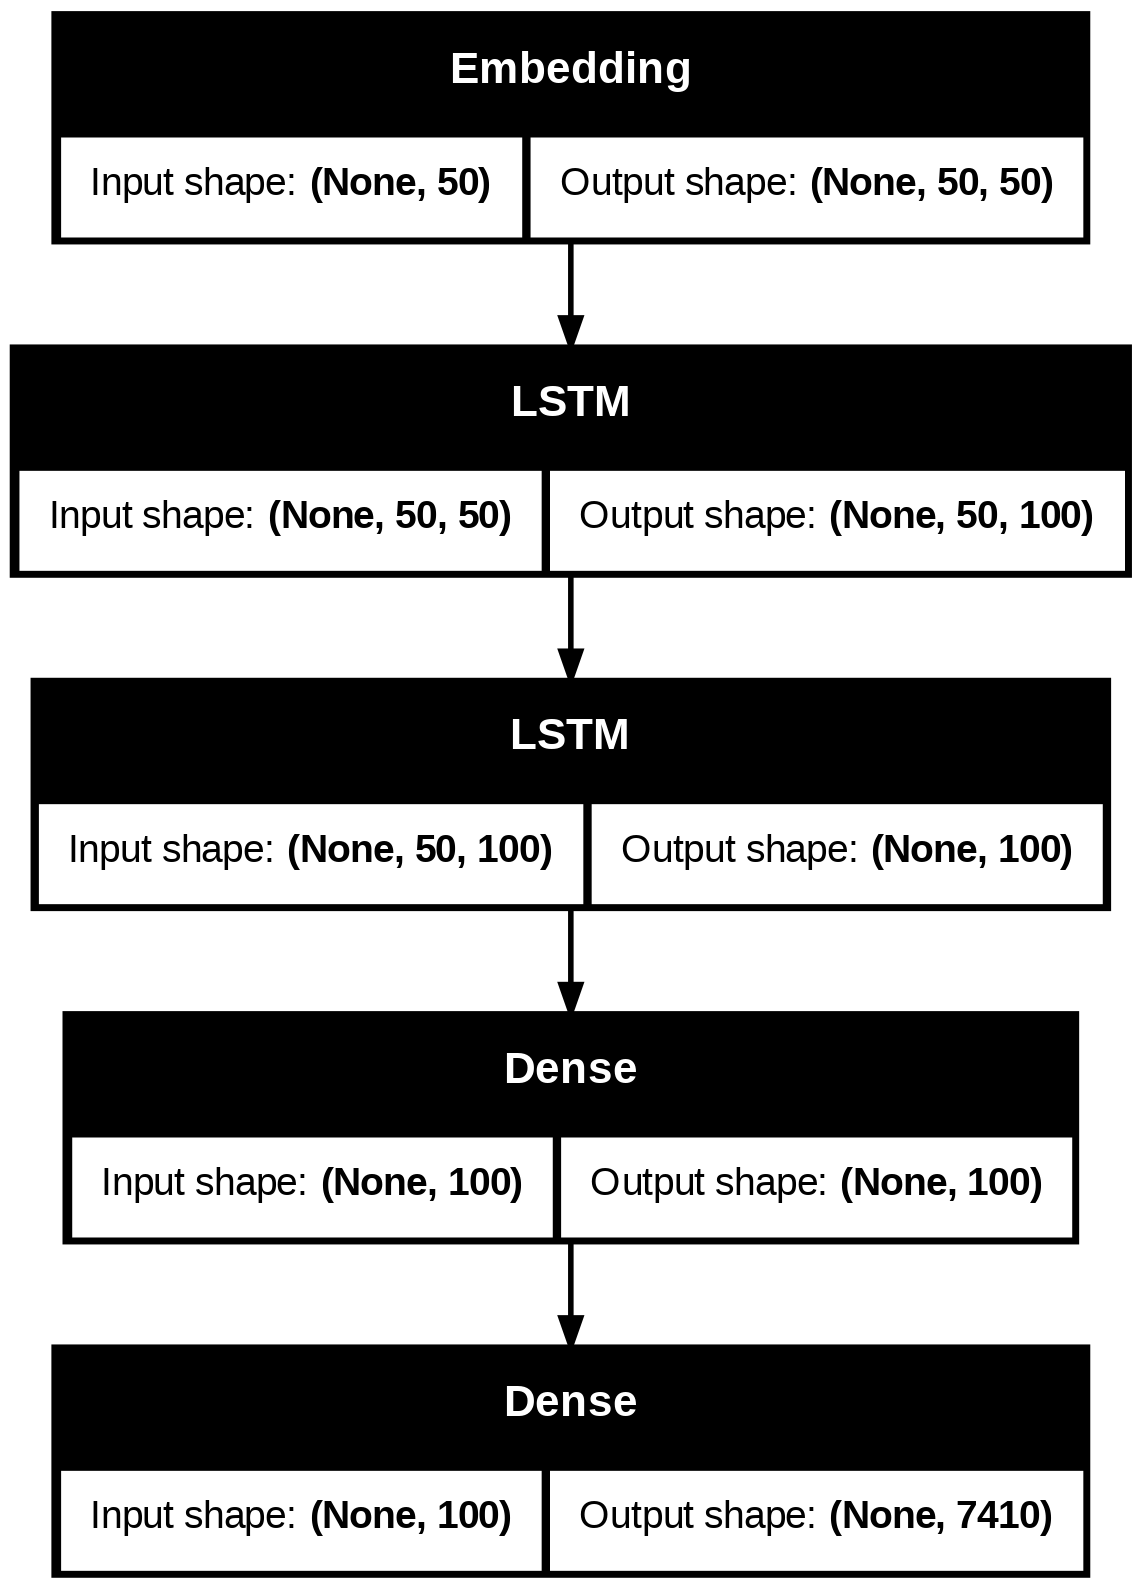

In [53]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [56]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [58]:
model.fit(X,y,batch_size=32,epochs=50)

Epoch 1/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.1699 - loss: 4.8552
Epoch 2/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.1752 - loss: 4.7494
Epoch 3/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.1783 - loss: 4.6628
Epoch 4/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.1835 - loss: 4.5869
Epoch 5/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.1864 - loss: 4.5170
Epoch 6/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.1898 - loss: 4.4572
Epoch 7/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.1922 - loss: 4.4108
Epoch 8/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.1960 - loss: 4.3523
Epoch 9/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.2003 - loss: 4.2901
Epoch 10/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.1998 - loss: 4.2472
Epoch 11/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.2032 - loss: 4.2104
Epoch 12/50
3708/37

## Using GloVe

In [59]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-07-27 20:54:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-27 20:54:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-27 20:54:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [62]:
!unzip /kaggle/working/glove.6B.zip -d /kaggle/working/


Archive:  /kaggle/working/glove.6B.zip
  inflating: /kaggle/working/glove.6B.50d.txt  
  inflating: /kaggle/working/glove.6B.100d.txt  
  inflating: /kaggle/working/glove.6B.200d.txt  
  inflating: /kaggle/working/glove.6B.300d.txt  


In [63]:
embedding_index = {}
with open('/kaggle/working/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [64]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

In [66]:
embedding_layer=Embedding(
    input_dim=vocab_size,
    output_dim=100,
    input_length=seq_length,
    weights=[embedding_matrix],
    trainable=False
)

In [67]:
model=Sequential()
model.add(embedding_layer)
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100,activation='relu'))
model.add(Dense(vocab_size,activation='softmax'))

In [68]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [69]:
model.fit(X,y,batch_size=32,epochs=50)

Epoch 1/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.0772 - loss: 6.2269
Epoch 2/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.1259 - loss: 5.5119
Epoch 3/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.1441 - loss: 5.2433
Epoch 4/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.1518 - loss: 5.0640
Epoch 5/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.1604 - loss: 4.9336
Epoch 6/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.1627 - loss: 4.8385
Epoch 7/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.1695 - loss: 4.7413
Epoch 8/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.1724 - loss: 4.6599
Epoch 9/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.1773 - loss: 4.5758
Epoch 10/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.1787 - loss: 4.5188
Epoch 11/50
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.1825 - loss: 4.4456
Epoch 12/50
3708/37

In [70]:
model.save('model.h5')
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [80]:

def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = []
    in_text = seed_text
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = np.argmax(model.predict(encoded, verbose=0), axis=-1)[0]
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)


In [77]:
from pickle import load
from tensorflow.keras.models import load_model


In [78]:
model = load_model('/kaggle/working/model.h5')
tokenizer = load(open('/kaggle/working/tokenizer.pkl', 'rb'))

In [90]:
sentence='i love deep'
generated_text=generate_seq(model,tokenizer,len(sentence.split(' ')),sentence,5)

In [91]:
print("generated text:", generated_text)
print("full sentence: ",sentence+' '+generated_text)

generated text: following labours and the shadows
full sentence:  i love deep following labours and the shadows
